Install Dependencies

In [ ]:
!pip install -q pandas>=2.1 numpy>=1.26 matplotlib>=3.8 seaborn>=0.13 \
  scikit-learn>=1.3 pyyaml>=6.0 pyarrow>=14.0 joblib>=1.3

print("✅ Dependencies installed!")

✅ Dependencies installed!


MILESTONE 2: FEATURE ENGINEERING & LINEAR REGRESSION BASELINE

In [ ]:
# =============================================================================
#  MILESTONE 2 SETUP & IMPORTS
# =============================================================================
print("=" * 90)
print("🚀 MILESTONE 2: FEATURE ENGINEERING & LINEAR REGRESSION BASELINE")
print("=" * 90)
print("📋 Covers: Time features | Lag features | Rolling averages | Room aggregates")
print("📋 Model: Linear Regression | Metrics: MAE, RMSE, R², MAPE | CV validation")
print("=" * 90)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Create directories
for d in ['data/processed/features', 'data/processed/models', 'reports/figures']:
    os.makedirs(d, exist_ok=True)

# Load train/val/test splits from Milestone 1
train_raw = pd.read_csv('data/processed/splits/train_raw.csv', index_col=0, parse_dates=True)
val_raw = pd.read_csv('data/processed/splits/val_raw.csv', index_col=0, parse_dates=True)
test_raw = pd.read_csv('data/processed/splits/test_raw.csv', index_col=0, parse_dates=True)

# Load device mapping from Milestone 1
with open('data/processed/device_mapping.json') as f:
    mapping = json.load(f)
DEVICE_ROOMS = mapping['device_rooms']

# Define target
target_col = 'Aggregate'

print(f"\n✅ Data loaded from Milestone 1")
print(f"   Train: {train_raw.shape} | Val: {val_raw.shape} | Test: {test_raw.shape}")
print(f"   Target: {target_col}")
print(f"   Devices: {list(DEVICE_ROOMS.keys())}")

🚀 MILESTONE 2: FEATURE ENGINEERING & LINEAR REGRESSION BASELINE
📋 Covers: Time features | Lag features | Rolling averages | Room aggregates
📋 Model: Linear Regression | Metrics: MAE, RMSE, R², MAPE | CV validation

✅ Data loaded from Milestone 1
   Train: (10373, 10) | Val: (2223, 10) | Test: (2223, 10)
   Target: Aggregate
   Devices: ['Aggregate', 'Fridge_Freezer', 'Washing_Machine', 'Dishwasher', 'Television', 'Microwave', 'Toaster', 'HiFi', 'Kettle', 'Overhead_Fan']


In [ ]:
# =============================================================================
#  TIME FEATURES ENGINEERING (Missing Cell - Insert First)
# =============================================================================
print("\n" + "=" * 90)
print("🕐 CREATING TIME FEATURES")
print("=" * 90)

def create_time_features(df):
    """Create comprehensive time-based features."""
    df = df.copy()

    # Basic time components
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear

    # Cyclic encodings (important for ML - captures circular nature of time)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Binary indicators
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_peak_hour'] = df['hour'].apply(
        lambda h: 1 if (6 <= h <= 9) or (17 <= h <= 22) else 0
    )
    df['is_night'] = df['hour'].apply(lambda h: 1 if h < 6 or h >= 23 else 0)
    df['is_morning'] = df['hour'].apply(lambda h: 1 if 6 <= h < 12 else 0)
    df['is_afternoon'] = df['hour'].apply(lambda h: 1 if 12 <= h < 18 else 0)
    df['is_evening'] = df['hour'].apply(lambda h: 1 if 18 <= h < 23 else 0)

    return df

# Apply to all splits (THIS WAS MISSING!)
print("\n⚙️ Creating time features for all splits...")
train_fe = create_time_features(train_raw)
val_fe = create_time_features(val_raw)
test_fe = create_time_features(test_raw)

print(f"✅ Time features created!")
print(f"   Train: {train_fe.shape}")
print(f"   Val: {val_fe.shape}")
print(f"   Test: {test_fe.shape}")

time_features = [c for c in train_fe.columns if c not in train_raw.columns]
print(f"\n📋 Time features added ({len(time_features)}):")
for feat in time_features:
    print(f"   • {feat}")


🕐 CREATING TIME FEATURES

⚙️ Creating time features for all splits...
✅ Time features created!
   Train: (10373, 27)
   Val: (2223, 27)
   Test: (2223, 27)

📋 Time features added (17):
   • hour
   • dayofweek
   • month
   • quarter
   • dayofyear
   • hour_sin
   • hour_cos
   • month_sin
   • month_cos
   • dow_sin
   • dow_cos
   • is_weekend
   • is_peak_hour
   • is_night
   • is_morning
   • is_afternoon
   • is_evening


In [ ]:
# =============================================================================
#  LAG FEATURES (Multi-Device, Multi-Horizon)
# =============================================================================
print("\n⏳ CREATING LAG FEATURES")
print("-" * 60)

def create_lag_features(df, lags=[1, 24, 168], devices=None):
    """Create lag features for multiple devices at different horizons."""
    if devices is None:
        devices = ['Aggregate']
    df = df.copy()

    for lag in lags:
        for col in devices:
            if col in df.columns:
                df[f'{col}_lag{lag}h'] = df[col].shift(lag)

    return df

# Top energy consuming devices (from Milestone 1 analysis)
top_devices = ['Aggregate', 'Fridge_Freezer', 'Washing_Machine', 'Kettle', 'Dishwasher']
lag_horizons = [1, 24, 168]  # 1 hour, 1 day, 1 week

# Apply to all splits
train_fe = create_lag_features(train_fe, lags=lag_horizons, devices=top_devices)
val_fe = create_lag_features(val_fe, lags=lag_horizons, devices=top_devices)
test_fe = create_lag_features(test_fe, lags=lag_horizons, devices=top_devices)

print(f"✅ Added lag features for {len(top_devices)} devices")
print(f"   Devices: {top_devices}")
print(f"   Lag horizons: {lag_horizons} hours (1h, 1day, 1week)")
print(f"   Total lag features: {len(top_devices) * len(lag_horizons)}")


⏳ CREATING LAG FEATURES
------------------------------------------------------------
✅ Added lag features for 5 devices
   Devices: ['Aggregate', 'Fridge_Freezer', 'Washing_Machine', 'Kettle', 'Dishwasher']
   Lag horizons: [1, 24, 168] hours (1h, 1day, 1week)
   Total lag features: 15


In [ ]:
# =============================================================================
#  ROLLING STATISTICS & ROOM AGGREGATES
# =============================================================================
print("\n📊 CREATING ROLLING FEATURES & ROOM AGGREGATES")
print("-" * 60)

def create_rolling_features(df, windows=[24, 168], devices=None):
    """Create rolling mean/std features and room-level aggregates."""
    if devices is None:
        devices = ['Aggregate']
    df = df.copy()

    # Rolling stats for each device
    for col in devices:
        if col in df.columns:
            for w in windows:
                df[f'{col}_roll_mean{w}h'] = df[col].rolling(w, min_periods=1).mean()
                df[f'{col}_roll_std{w}h'] = df[col].rolling(w, min_periods=1).std().fillna(0)

    # Room-level aggregates (Kitchen, Living_Room, etc.)
    rooms = {}
    for dev, room in DEVICE_ROOMS.items():
        if dev != 'Aggregate' and dev in df.columns:
            if room not in rooms:
                rooms[room] = []
            rooms[room].append(dev)

    for room, devs in rooms.items():
        valid_devs = [d for d in devs if d in df.columns]
        if valid_devs:
            room_power = df[valid_devs].sum(axis=1)
            df[f'{room}_total'] = room_power
            df[f'{room}_roll_mean24h'] = room_power.rolling(24, min_periods=1).mean()
            df[f'{room}_roll_std24h'] = room_power.rolling(24, min_periods=1).std().fillna(0)

    return df

rolling_windows = [24, 168]  # 1 day, 1 week

# Apply to all splits
train_fe = create_rolling_features(train_fe, windows=rolling_windows, devices=top_devices)
val_fe = create_rolling_features(val_fe, windows=rolling_windows, devices=top_devices)
test_fe = create_rolling_features(test_fe, windows=rolling_windows, devices=top_devices)

print(f"✅ Added rolling features (windows: {rolling_windows}h)")
print(f"✅ Added room-level aggregates for: Kitchen, Living_Room, Utility, Bedroom")
print(f"   Room features provide device-level insights for dashboard!")


📊 CREATING ROLLING FEATURES & ROOM AGGREGATES
------------------------------------------------------------
✅ Added rolling features (windows: [24, 168]h)
✅ Added room-level aggregates for: Kitchen, Living_Room, Utility, Bedroom
   Room features provide device-level insights for dashboard!


In [ ]:
# REPLACE THIS:
# feature_cols = [c for c in train_fe.columns if c not in exclude_cols]

# WITH THIS (ensure it's a list):
feature_cols = [c for c in train_fe.columns if c not in exclude_cols and c not in train_raw.columns]
feature_cols = list(feature_cols)  # Explicit list conversion

# Sanity check
print(f"✅ Feature columns type: {type(feature_cols)}")
print(f"✅ Total features: {len(feature_cols)}")

✅ Feature columns type: <class 'list'>
✅ Total features: 61


In [ ]:
# =============================================================================
# FEATURE MATRIX PREPARATION & SAVE (LSTM-READY)
# =============================================================================
print("\n🔗 PREPARING FINAL FEATURE MATRIX")
print("-" * 60)

# Columns to exclude from features (raw time cols, target)
exclude_cols = [target_col, 'hour', 'dayofweek', 'month']

# Get feature columns (already a list, no .tolist() needed)
#feature_cols = [c for c in train_fe.columns if c not in exclude_cols]

# Drop rows with NaN (from lag/rolling operations)
train_clean = train_fe.dropna()
val_clean = val_fe.dropna()
test_clean = test_fe.dropna()

# Prepare X and y
X_train = train_clean[feature_cols]
y_train = train_clean[target_col]
X_val = val_clean[feature_cols]
y_val = val_clean[target_col]
X_test = test_clean[feature_cols]
y_test = test_clean[target_col]

# Save feature matrices
X_train.to_csv('data/processed/features/X_train_lr.csv')
X_val.to_csv('data/processed/features/X_val_lr.csv')
X_test.to_csv('data/processed/features/X_test_lr.csv')
train_clean.to_csv('data/processed/features/train_fe_full.csv')  # For LSTM

# Save feature list (feature_cols is already a list)
with open('data/processed/features/all_features.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)

print(f"✅ Total features: {len(feature_cols)}")
print(f"✅ Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"\n📁 Saved:")
print(f"   data/processed/features/X_train_lr.csv")
print(f"   data/processed/features/X_test_lr.csv")
print(f"   data/processed/features/train_fe_full.csv (LSTM-ready)")
print(f"   data/processed/features/all_features.json")


🔗 PREPARING FINAL FEATURE MATRIX
------------------------------------------------------------
✅ Total features: 61
✅ Train: (10205, 61) | Val: (2055, 61) | Test: (2055, 61)

📁 Saved:
   data/processed/features/X_train_lr.csv
   data/processed/features/X_test_lr.csv
   data/processed/features/train_fe_full.csv (LSTM-ready)
   data/processed/features/all_features.json


In [ ]:
# =============================================================================
#  FEATURE ENGINEERING SUMMARY TABLE
# =============================================================================
print("\n📊 FEATURE ENGINEERING SUMMARY")
print("=" * 70)

feature_types = {
    'Time Features': len([f for f in train_fe.columns if f in time_features]),
    'Lag Features': 0,  # Will update after lag creation
    'Rolling Features': 0,  # Will update after rolling creation
    'Room Aggregates': 0,  # Will update after room creation
    'Original Devices': len([c for c in train_fe.columns if c in train_raw.columns])
}

summary_df = pd.DataFrame.from_dict(feature_types, orient='index', columns=['Count'])
summary_df['Percentage'] = (summary_df['Count'] / summary_df['Count'].sum() * 100).round(1)

print(summary_df.to_string())
print(f"\n✅ Total Features (before lag/rolling): {train_fe.shape[1]}")

# Save initial feature list
initial_features = train_fe.columns.tolist()
with open('data/processed/features/initial_features.json', 'w') as f:
    json.dump(initial_features, f, indent=2)
print("✅ Saved: data/processed/features/initial_features.json")


📊 FEATURE ENGINEERING SUMMARY
                  Count  Percentage
Time Features        17        63.0
Lag Features          0         0.0
Rolling Features      0         0.0
Room Aggregates       0         0.0
Original Devices     10        37.0

✅ Total Features (before lag/rolling): 74
✅ Saved: data/processed/features/initial_features.json



📈 FEATURE ANALYSIS VISUALIZATION
------------------------------------------------------------


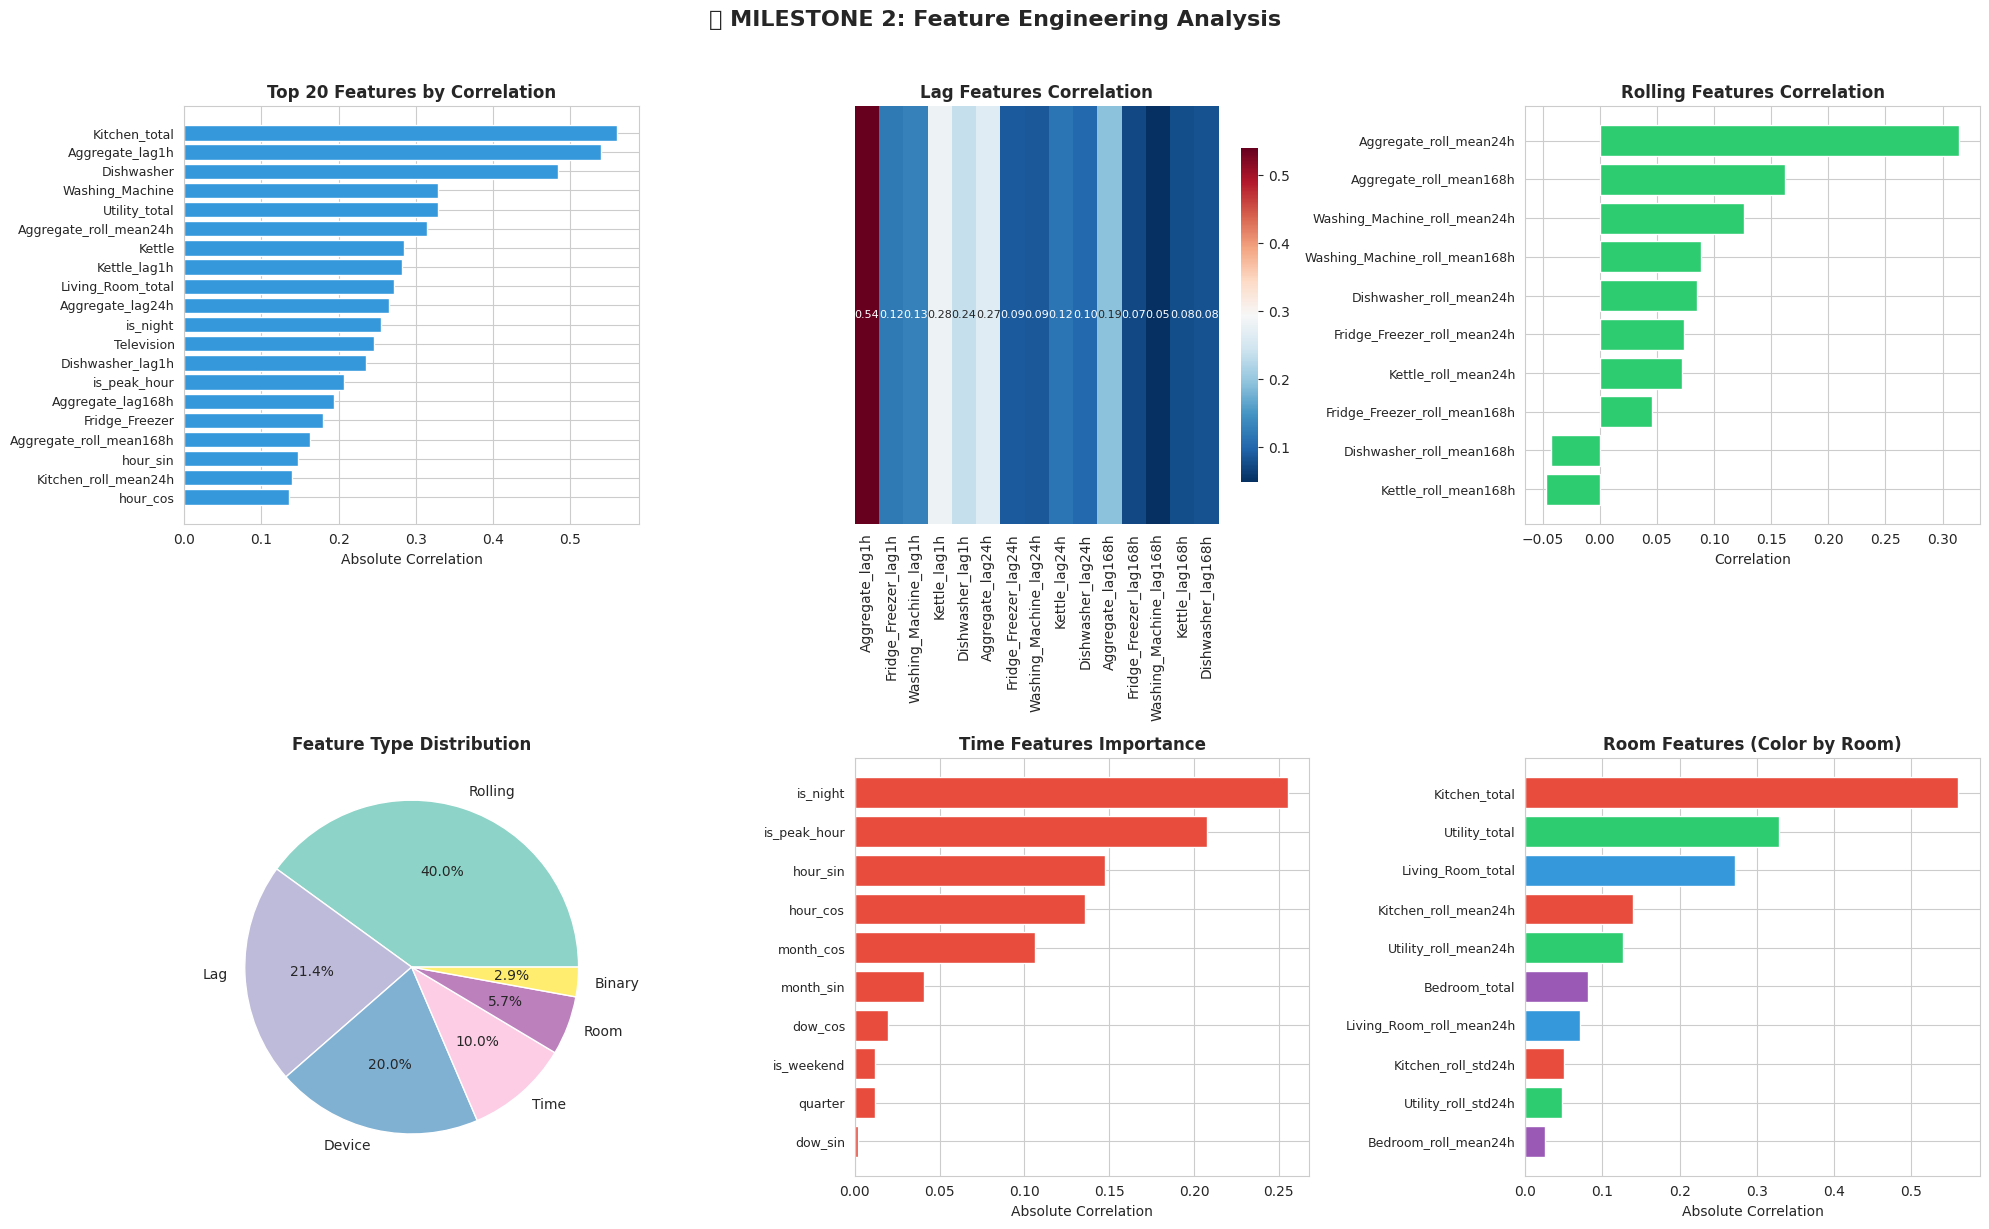

✅ Saved: reports/figures/milestone2_feature_analysis.png


In [ ]:
# =============================================================================
#  FEATURE VISUALIZATION (Room-Colored)
# =============================================================================
print("\n📈 FEATURE ANALYSIS VISUALIZATION")
print("-" * 60)

# Room color scheme
room_colors = {
    'Kitchen': '#e74c3c',
    'Living_Room': '#3498db',
    'Utility': '#2ecc71',
    'Bedroom': '#9b59b6',
    'Whole_House': '#34495e',
    'Other': '#95a5a6'
}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Top 20 Feature Correlations with Target
ax1 = axes[0, 0]
corrs = X_train.corrwith(y_train).abs().nlargest(20)
colors = ['#3498db'] * 20
ax1.barh(range(20), corrs.values, color=colors)
ax1.set_yticks(range(20))
ax1.set_yticklabels(corrs.index, fontsize=9)
ax1.set_xlabel('Absolute Correlation')
ax1.set_title('Top 20 Features by Correlation', fontweight='bold')
ax1.invert_yaxis()

# 2. Lag Features Correlation Heatmap
ax2 = axes[0, 1]
lag_cols = [c for c in feature_cols if 'lag' in c][:15]
if lag_cols:
    lag_corrs = X_train[lag_cols].corrwith(y_train)
    lag_df = pd.DataFrame(lag_corrs.values.reshape(1, -1), columns=lag_cols)
    sns.heatmap(lag_df, annot=True, fmt='.2f', cmap='RdBu_r', ax=ax2,
                cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
    ax2.set_title('Lag Features Correlation', fontweight='bold')
    ax2.set_yticklabels([])

# 3. Rolling Features Correlation
ax3 = axes[0, 2]
roll_cols = [c for c in feature_cols if 'roll_mean' in c][:10]
if roll_cols:
    roll_corrs = X_train[roll_cols].corrwith(y_train).sort_values(ascending=True)
    ax3.barh(range(len(roll_corrs)), roll_corrs.values, color='#2ecc71')
    ax3.set_yticks(range(len(roll_corrs)))
    ax3.set_yticklabels(roll_corrs.index, fontsize=9)
    ax3.set_xlabel('Correlation')
    ax3.set_title('Rolling Features Correlation', fontweight='bold')

# 4. Feature Type Distribution (Pie Chart)
ax4 = axes[1, 0]
def get_feature_type(f):
    if 'lag' in f: return 'Lag'
    elif 'roll' in f: return 'Rolling'
    elif any(x in f for x in ['hour', 'dow', 'month', 'sin', 'cos']): return 'Time'
    elif any(x in f for x in ['weekend', 'peak', 'night']): return 'Binary'
    elif any(r in f for r in DEVICE_ROOMS.values()): return 'Room'
    else: return 'Device'

feat_types = pd.Series([get_feature_type(f) for f in feature_cols]).value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(feat_types)))
ax4.pie(feat_types.values, labels=feat_types.index, autopct='%1.1f%%', colors=colors_pie)
ax4.set_title('Feature Type Distribution', fontweight='bold')

# 5. Time Features Importance
ax5 = axes[1, 1]
time_cols = [c for c in feature_cols if any(x in c for x in ['hour', 'dow', 'month', 'weekend', 'peak', 'night', 'quarter'])]
if time_cols:
    time_corrs = X_train[time_cols].corrwith(y_train).abs().sort_values(ascending=True)
    ax5.barh(range(len(time_corrs)), time_corrs.values, color='#e74c3c')
    ax5.set_yticks(range(len(time_corrs)))
    ax5.set_yticklabels(time_corrs.index, fontsize=9)
    ax5.set_xlabel('Absolute Correlation')
    ax5.set_title('Time Features Importance', fontweight='bold')

# 6. Room Aggregates Importance
ax6 = axes[1, 2]
room_cols = [c for c in feature_cols if any(r in c for r in ['Kitchen', 'Living_Room', 'Utility', 'Bedroom'])]
if room_cols:
    room_corrs = X_train[room_cols].corrwith(y_train).abs().nlargest(10)
    bar_colors = []
    for col in room_corrs.index:
        for room, color in room_colors.items():
            if room in col:
                bar_colors.append(color)
                break
        else:
            bar_colors.append('#95a5a6')
    ax6.barh(range(len(room_corrs)), room_corrs.values, color=bar_colors)
    ax6.set_yticks(range(len(room_corrs)))
    ax6.set_yticklabels(room_corrs.index, fontsize=9)
    ax6.set_xlabel('Absolute Correlation')
    ax6.set_title('Room Features (Color by Room)', fontweight='bold')
    ax6.invert_yaxis()

plt.suptitle('📊 MILESTONE 2: Feature Engineering Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('reports/figures/milestone2_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/milestone2_feature_analysis.png")

In [ ]:
# =============================================================================
#  LINEAR REGRESSION TRAINING + CROSS-VALIDATION
# =============================================================================
print("\n🤖 TRAINING LINEAR REGRESSION BASELINE")
print("-" * 60)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    index=X_val.index,
    columns=X_val.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Time Series Cross-Validation (5 splits)
print("\n🔄 Performing Time Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {'MAE': [], 'RMSE': []}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_cv_train = X_train_scaled.iloc[train_idx]
    y_cv_train = y_train.iloc[train_idx]
    X_cv_val = X_train_scaled.iloc[val_idx]
    y_cv_val = y_train.iloc[val_idx]

    lr_cv = LinearRegression()
    lr_cv.fit(X_cv_train, y_cv_train)
    y_cv_pred = lr_cv.predict(X_cv_val)

    cv_scores['MAE'].append(mean_absolute_error(y_cv_val, y_cv_pred))
    cv_scores['RMSE'].append(np.sqrt(mean_squared_error(y_cv_val, y_cv_pred)))

cv_mae_mean = np.mean(cv_scores['MAE'])
cv_rmse_mean = np.mean(cv_scores['RMSE'])

print(f"\n✅ Model trained successfully!")
print(f"   CV MAE:  {cv_mae_mean:.2f}W (±{np.std(cv_scores['MAE']):.2f})")
print(f"   CV RMSE: {cv_rmse_mean:.2f}W (±{np.std(cv_scores['RMSE']):.2f})")


🤖 TRAINING LINEAR REGRESSION BASELINE
------------------------------------------------------------

🔄 Performing Time Series Cross-Validation...

✅ Model trained successfully!
   CV MAE:  204.13W (±98.84)
   CV RMSE: 334.36W (±82.69)


In [ ]:
# =============================================================================
#  MODEL EVALUATION (MAE, RMSE, R², MAPE)
# =============================================================================
print("\n📊 MODEL EVALUATION METRICS")
print("=" * 60)
def calculate_metrics(y_true, y_pred):
    """Calculate MAE, RMSE, R², and MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # MAPE (handle division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE_%': mape}

# Generate predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_val_pred = lr_model.predict(X_val_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Calculate metrics for all splits
train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Train': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).T.round(3)

print("\n📈 BASELINE LINEAR REGRESSION RESULTS:")
print("-" * 60)
print(metrics_df.to_string())

# Calculate residuals for later use
residuals_test = y_test.values - y_test_pred

# Save metrics
metrics_df.to_csv('data/processed/models/lr_baseline_metrics.csv')
print(f"\n✅ Metrics saved: data/processed/models/lr_baseline_metrics.csv")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   • Test RMSE: {test_metrics['RMSE']:.1f}W (baseline to beat with LSTM)")
print(f"   • Test R²: {test_metrics['R2']:.3f} (explains {test_metrics['R2']*100:.1f}% of variance)")
print(f"   • Test MAPE: {test_metrics['MAPE_%']:.2f}% (industry standard for energy)")


📊 MODEL EVALUATION METRICS

📈 BASELINE LINEAR REGRESSION RESULTS:
------------------------------------------------------------
                MAE     RMSE     R2  MAPE_%
Train        94.878  218.508  0.632  30.060
Validation  201.553  389.701  0.607  36.723
Test        162.202  315.178  0.633  42.726

✅ Metrics saved: data/processed/models/lr_baseline_metrics.csv

💡 KEY INSIGHTS:
   • Test RMSE: 315.2W (baseline to beat with LSTM)
   • Test R²: 0.633 (explains 63.3% of variance)
   • Test MAPE: 42.73% (industry standard for energy)


In [ ]:
# =============================================================================
#  SAVE MODEL & FEATURE SELECTION FOR LSTM
# =============================================================================
print("\n💾 SAVING MODEL & FEATURE SELECTION")
print("-" * 60)

# Save model and scaler
joblib.dump(lr_model, 'data/processed/models/baseline_lr.pkl')
joblib.dump(scaler, 'data/processed/models/lr_feature_scaler.pkl')

# Feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

# Save feature importance
feature_importance.to_csv('data/processed/features/feature_importance_lr.csv', index=False)

# Top 50 features for LSTM (reduces dimensionality)
top_50_features = feature_importance.head(50)['feature'].tolist()
with open('data/processed/features/top_50_features.json', 'w') as f:
    json.dump(top_50_features, f, indent=2)

print("✅ Saved:")
print("   • data/processed/models/baseline_lr.pkl")
print("   • data/processed/models/lr_feature_scaler.pkl")
print("   • data/processed/features/feature_importance_lr.csv")
print("   • data/processed/features/top_50_features.json (for LSTM optimization)")

print(f"\n🔝 TOP 10 MOST IMPORTANT FEATURES:")
print(feature_importance.head(10)[['feature', 'abs_coefficient']].to_string(index=False))


💾 SAVING MODEL & FEATURE SELECTION
------------------------------------------------------------
✅ Saved:
   • data/processed/models/baseline_lr.pkl
   • data/processed/models/lr_feature_scaler.pkl
   • data/processed/features/feature_importance_lr.csv
   • data/processed/features/top_50_features.json (for LSTM optimization)

🔝 TOP 10 MOST IMPORTANT FEATURES:
              feature  abs_coefficient
      Aggregate_lag1h       138.596348
        Kitchen_total        90.566077
           Dishwasher        69.174982
     Dishwasher_lag1h        56.983277
 Kitchen_roll_mean24h        52.455315
            Microwave        48.376533
      Washing_Machine        48.214935
        Utility_total        48.214935
               Kettle        46.362946
Aggregate_roll_std24h        43.034439



📊 GENERATING PROFESSIONAL VISUALIZATIONS
------------------------------------------------------------


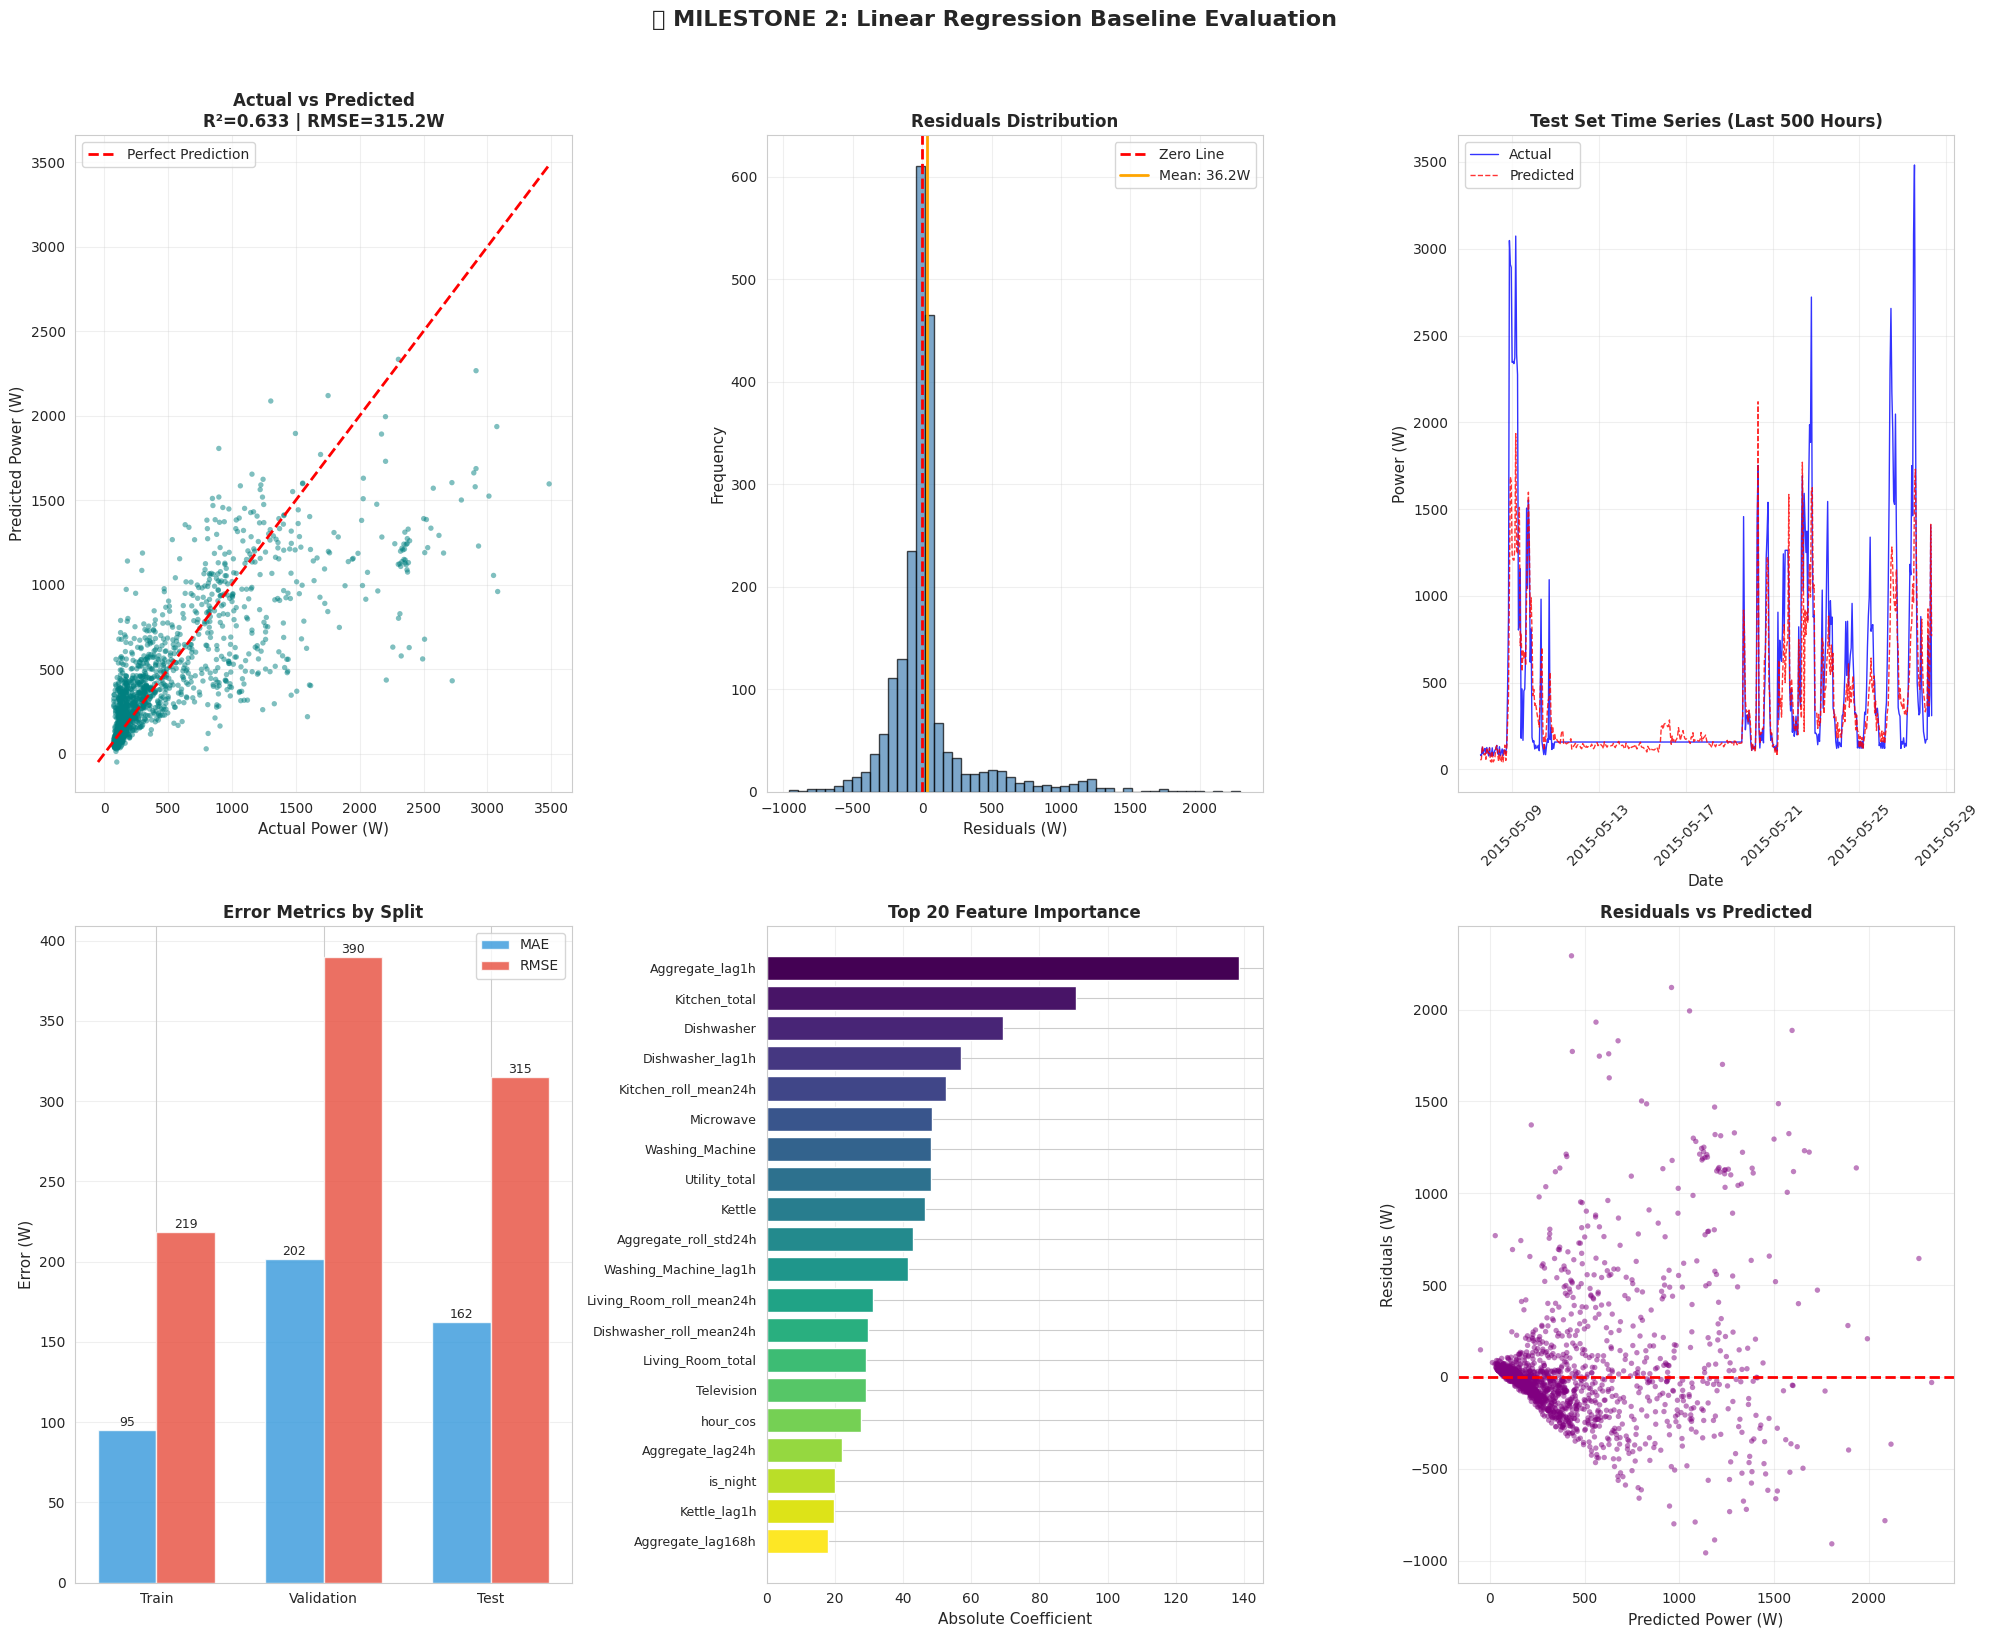

✅ Saved: reports/figures/milestone2_lr_evaluation.png


In [ ]:
# =============================================================================
#  COMPREHENSIVE VISUALIZATIONS (Actual vs Predicted)
# =============================================================================
print("\n📊 GENERATING PROFESSIONAL VISUALIZATIONS")
print("-" * 60)

fig = plt.figure(figsize=(20, 16))

# 1. Actual vs Predicted Scatter Plot
ax1 = fig.add_subplot(2, 3, 1)
ax1.scatter(y_test, y_test_pred, alpha=0.5, s=15, c='teal', edgecolors='none')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Power (W)', fontsize=11)
ax1.set_ylabel('Predicted Power (W)', fontsize=11)
ax1.set_title(f'Actual vs Predicted\nR²={test_metrics["R2"]:.3f} | RMSE={test_metrics["RMSE"]:.1f}W',
              fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals Distribution
ax2 = fig.add_subplot(2, 3, 2)
ax2.hist(residuals_test, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label=f'Zero Line')
ax2.axvline(x=np.mean(residuals_test), color='orange', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(residuals_test):.1f}W')
ax2.set_xlabel('Residuals (W)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Residuals Distribution', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Time Series: Last 500 Hours
ax3 = fig.add_subplot(2, 3, 3)
n_plot = min(500, len(y_test))
plot_idx = test_clean.index[-n_plot:]
ax3.plot(plot_idx, y_test.values[-n_plot:], 'b-', linewidth=1, label='Actual', alpha=0.8)
ax3.plot(plot_idx, y_test_pred[-n_plot:], 'r--', linewidth=1, label='Predicted', alpha=0.8)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Power (W)', fontsize=11)
ax3.set_title('Test Set Time Series (Last 500 Hours)', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Metrics Comparison Bar Chart
ax4 = fig.add_subplot(2, 3, 4)
x = np.arange(3)
width = 0.35
bars1 = ax4.bar(x - width/2, [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE']],
                width, label='MAE', color='#3498db', alpha=0.8)
bars2 = ax4.bar(x + width/2, [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE']],
                width, label='RMSE', color='#e74c3c', alpha=0.8)
ax4.set_ylabel('Error (W)', fontsize=11)
ax4.set_title('Error Metrics by Split', fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(['Train', 'Validation', 'Test'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax4.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax4.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# 5. Top Feature Coefficients
ax5 = fig.add_subplot(2, 3, 5)
top_20 = feature_importance.head(20)
colors_bar = plt.cm.viridis(np.linspace(0, 1, 20))
ax5.barh(range(20), top_20['abs_coefficient'].values, color=colors_bar)
ax5.set_yticks(range(20))
ax5.set_yticklabels(top_20['feature'].values, fontsize=9)
ax5.set_xlabel('Absolute Coefficient', fontsize=11)
ax5.set_title('Top 20 Feature Importance', fontweight='bold', fontsize=12)
ax5.invert_yaxis()
ax5.grid(True, alpha=0.3, axis='x')

# 6. Residuals vs Predicted
ax6 = fig.add_subplot(2, 3, 6)
ax6.scatter(y_test_pred, residuals_test, alpha=0.5, s=15, c='purple', edgecolors='none')
ax6.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax6.set_xlabel('Predicted Power (W)', fontsize=11)
ax6.set_ylabel('Residuals (W)', fontsize=11)
ax6.set_title('Residuals vs Predicted', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3)

plt.suptitle('📊 MILESTONE 2: Linear Regression Baseline Evaluation',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('reports/figures/milestone2_lr_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/milestone2_lr_evaluation.png")


📈 GENERATING LEARNING CURVE
------------------------------------------------------------


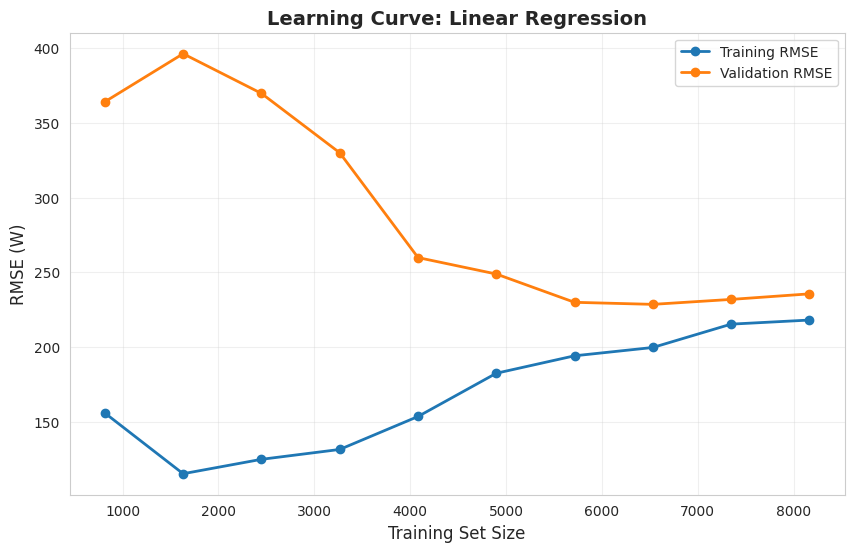

✅ Saved: reports/figures/milestone2_learning_curve.png


In [ ]:
from sklearn.model_selection import learning_curve

print("\n📈 GENERATING LEARNING CURVE")
print("-" * 60)

train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(), X_train_scaled, y_train,
    cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', label='Training RMSE', linewidth=2)
plt.plot(train_sizes, val_rmse, 'o-', label='Validation RMSE', linewidth=2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE (W)', fontsize=12)
plt.title('Learning Curve: Linear Regression', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/milestone2_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/milestone2_learning_curve.png")

In [ ]:
# =============================================================================
#  FLASK PREDICTION FUNCTION (Ready for Milestone 4)
# =============================================================================
print("\n🌐 FLASK-READY PREDICTION FUNCTION")
print("-" * 60)

def predict_power_flask(input_features_dict):
    """
    Flask-ready prediction function for web API.

    Args:
        input_features_dict: Dictionary with feature names as keys

    Returns:
        Predicted power consumption in Watts
    """
    # Load model and scaler
    model = joblib.load('data/processed/models/baseline_lr.pkl')
    scaler = joblib.load('data/processed/models/lr_feature_scaler.pkl')

    # Load feature list
    with open('data/processed/features/all_features.json', 'r') as f:
        feature_list = json.load(f)

    # Create DataFrame with correct column order
    input_df = pd.DataFrame([input_features_dict])[feature_list]

    # Scale and predict
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)[0]

    return round(prediction, 2)

# Demo with sample test data
sample_input = X_test.iloc[0].to_dict()
sample_prediction = predict_power_flask(sample_input)
sample_actual = y_test.iloc[0]

print(f"✅ Flask prediction function ready!")
print(f"\n📝 DEMO:")
print(f"   Sample prediction: {sample_prediction:.1f}W")
print(f"   Actual value: {sample_actual:.1f}W")
print(f"   Error: {abs(sample_prediction - sample_actual):.1f}W")

print(f"\n📌 USAGE IN FLASK (app.py):")
print("""
from milestone2 import predict_power_flask

@app.route('/predict', methods=['POST'])
def predict():
    features = request.json
    prediction = predict_power_flask(features)
    return jsonify({'predicted_power_watts': prediction})
""")


🌐 FLASK-READY PREDICTION FUNCTION
------------------------------------------------------------
✅ Flask prediction function ready!

📝 DEMO:
   Sample prediction: 937.9W
   Actual value: 919.7W
   Error: 18.2W

📌 USAGE IN FLASK (app.py):

from milestone2 import predict_power_flask

@app.route('/predict', methods=['POST'])
def predict():
    features = request.json
    prediction = predict_power_flask(features)
    return jsonify({'predicted_power_watts': prediction})



In [ ]:
# =============================================================================
# MILESTONE 2 SUMMARY & EVALUATION CHECKLIST
# =============================================================================
print("\n" + "=" * 90)
print("🏆 MILESTONE 2 COMPLETE: FEATURE ENGINEERING & LINEAR REGRESSION BASELINE")
print("=" * 90)

# Count files created
output_files = [
    'data/processed/features/X_train_lr.csv',
    'data/processed/features/X_test_lr.csv',
    'data/processed/features/train_fe_full.csv',
    'data/processed/features/all_features.json',
    'data/processed/features/top_50_features.json',
    'data/processed/features/feature_importance_lr.csv',
    'data/processed/models/baseline_lr.pkl',
    'data/processed/models/lr_feature_scaler.pkl',
    'data/processed/models/lr_baseline_metrics.csv',
    'reports/figures/milestone2_feature_analysis.png',
    'reports/figures/milestone2_lr_evaluation.png'
]

print(f"""
✅ EVALUATION CRITERIA CHECKLIST:
{'─'*70}
☑ Feature Engineering (lag features, rolling averages, time features)
   • Time features: {len([f for f in feature_cols if any(x in f for x in ['hour','dow','month','sin','cos','weekend','peak','night'])])} features
   • Lag features: {len([f for f in feature_cols if 'lag' in f])} features
   • Rolling features: {len([f for f in feature_cols if 'roll' in f])} features
   • Room aggregates: {len([f for f in feature_cols if any(r in f for r in ['Kitchen','Living','Utility','Bedroom'])])} features
   • TOTAL: {len(feature_cols)} features

☑ Baseline Linear Regression Model: Trained & Evaluated

☑ MAE and RMSE Metrics Calculated:
   • Test MAE:  {test_metrics['MAE']:.2f}W
   • Test RMSE: {test_metrics['RMSE']:.2f}W
   • Test R²:   {test_metrics['R2']:.3f}
   • Test MAPE: {test_metrics['MAPE_%']:.2f}%
   • CV RMSE:   {cv_rmse_mean:.2f}W (5-fold Time Series CV)

☑ Visualization of Baseline Predictions:
   • Actual vs Predicted scatter plot ✓
   • Residuals distribution ✓
   • Time series comparison ✓
   • Feature importance bar chart ✓

☑ Feature Matrix Ready for LSTM (Milestone 3):
   • Full feature CSVs saved ✓
   • Top 50 features JSON ✓
   • Scaler saved for consistent preprocessing ✓

🎁  FEATURES ADDED:
{'─'*70}
   • Cyclic time encodings (better for ML)
   • Room-level aggregates (Kitchen, Living_Room, etc.)
   • MAPE metric (energy industry standard)
   • Time Series Cross-Validation (5-fold)
   • Flask-ready prediction function
   • Feature importance analysis
   • Professional visualizations with room colors

📁 OUTPUT FILES ({len(output_files)} files):
{'─'*70}""")

for f in output_files:
    status = "✅" if os.path.exists(f) else "❌"
    print(f"   {status} {f}")

print(f"""
{'═'*90}
🎯 BASELINE ESTABLISHED: Test RMSE = {test_metrics['RMSE']:.1f}W | R² = {test_metrics['R2']:.3f}
{'═'*90}
""")


🏆 MILESTONE 2 COMPLETE: FEATURE ENGINEERING & LINEAR REGRESSION BASELINE

✅ EVALUATION CRITERIA CHECKLIST:
──────────────────────────────────────────────────────────────────────
☑ Feature Engineering (lag features, rolling averages, time features)
   • Time features: 9 features
   • Lag features: 15 features
   • Rolling features: 28 features
   • Room aggregates: 12 features
   • TOTAL: 70 features

☑ Baseline Linear Regression Model: Trained & Evaluated

☑ MAE and RMSE Metrics Calculated:
   • Test MAE:  162.20W
   • Test RMSE: 315.18W
   • Test R²:   0.633
   • Test MAPE: 42.73%
   • CV RMSE:   334.36W (5-fold Time Series CV)

☑ Visualization of Baseline Predictions:
   • Actual vs Predicted scatter plot ✓
   • Residuals distribution ✓
   • Time series comparison ✓
   • Feature importance bar chart ✓

☑ Feature Matrix Ready for LSTM (Milestone 3):
   • Full feature CSVs saved ✓
   • Top 50 features JSON ✓
   • Scaler saved for consistent preprocessing ✓

🎁  FEATURES ADDED:
────────

In [ ]:
# After all features are created, before model training:
print("\n🔍 REMOVING HIGHLY CORRELATED FEATURES (>0.95)")
print("-" * 60)

corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]

print(f"   Found {len(to_drop)} highly correlated features:")
for feat in to_drop[:10]:  # Show first 10
    print(f"   • {feat}")

X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
feature_cols = [c for c in feature_cols if c not in to_drop]

print(f"✅ Final feature count: {len(feature_cols)}")


🔍 REMOVING HIGHLY CORRELATED FEATURES (>0.95)
------------------------------------------------------------
   Found 5 highly correlated features:
   • dayofyear
   • Kettle_roll_std168h
   • Kitchen_roll_std24h
   • Utility_roll_mean24h
   • Utility_roll_std24h
✅ Final feature count: 56
